In [30]:
import numpy as np
import pylab as plt
from simulate_network import run_simulation, plot_LFP
%matplotlib inline

We will obtain data from a network of spiking neurons. The data is a LFP-like signal obtained from 8 channels corresponding to different neural populations from which the signal is measured.
The function *run_simulation* takes 5 optional arguments:
* t_sim
  [ms] simulation time (will be the length of the time dimension in ms).
* stim_strength
  [Hz] strength of external stimulation in Hz (if 0 no stimulation is applied).
* stim_start
  [ms] start of the applied external stimulation in ms.
* stim_dur
  [ms] duration of the applied external stimulation in ms.
* population
  *int* 0 to 7. refering to the population that the stimulation will be applied to.

The function returns a numpy array which has a time-series for each of the populations.

In [31]:
data = run_simulation(t_sim=1000, stim_strength=50, stim_start=500, stim_dur=10, population=0)

Run spiking neural network...
Collect data from file...
	Population 1/8
	Population 2/8
	Population 3/8
	Population 4/8
	Population 5/8
	Population 6/8
	Population 7/8
	Population 8/8


<Figure size 640x480 with 0 Axes>

In [32]:
print(data)
data.shape

[[-61.00364233 -61.94559172 -62.6648617  ... -60.22426596 -60.70281415
  -61.14042956]
 [-56.76535849 -57.41341281 -57.89351001 ... -56.31358662 -56.56813093
  -56.93028816]
 [-58.04321624 -58.12374589 -58.17365633 ... -58.21022597 -58.09336785
  -57.88490389]
 ...
 [-56.77854403 -57.02744654 -57.29131447 ... -56.72475157 -57.01997799
  -57.26549057]
 [-61.20715116 -61.56571273 -61.6108294  ... -61.96444259 -62.50974213
  -62.58279792]
 [-56.67891412 -56.83168023 -56.69714237 ... -57.30430395 -57.60705085
  -57.61083503]]


(8, 998)

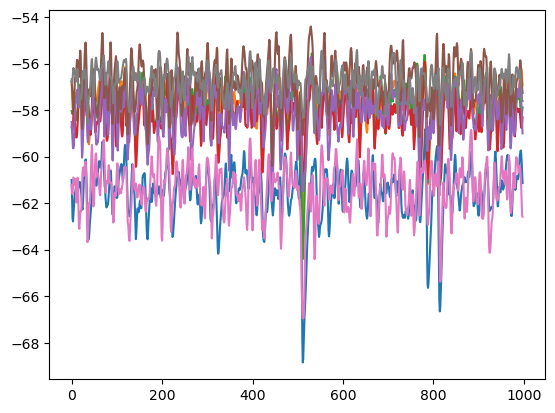

In [33]:
plt.plot(data.T)

In [34]:
len(data[0])

998

In [56]:
def DMD(data, r):
    """Dynamic Mode Decomposition (DMD) algorithm."""
    
    ## Build data matrices
    X1 = data[:, : -1]
    X2 = data[:, 1 :]
    ## Perform singular value decomposition on X1
    u, s, v = np.linalg.svd(X1, full_matrices = False)
    ## Compute the Koopman matrix
    A_tilde = u[:, : r].conj().T @ X2 @ v[: r, :].conj().T * np.reciprocal(s[: r])
    ## Perform eigenvalue decomposition on A_tilde
    Phi, Q = np.linalg.eig(A_tilde)
    ## Compute the coefficient matrix
    Psi = X2 @ v[: r, :].conj().T @ np.diag(np.reciprocal(s[: r])) @ Q
    A = Psi @ np.diag(Phi) @ np.linalg.pinv(Psi)
    
    return A_tilde, Phi, A

def DMD4cast(data, r, pred_step):
    N, T = data.shape
    _, _, A = DMD(data, r)
    mat = np.append(data, np.zeros((N, pred_step)), axis = 1)
    for s in range(pred_step):
        mat[:, T + s] = (A @ mat[:, T + s - 1]).real
    return mat[:, - pred_step :]


In [92]:
# Koopman matrix, eigenvalues, and coefficient matrix. 
A_tilde, Phi, A = DMD(data, 8)
print(Phi)

[0.99999425+0.j         0.93646673+0.14175335j 0.93646673-0.14175335j
 0.93306769+0.08666559j 0.93306769-0.08666559j 0.91027334+0.j
 0.9319955 +0.01976353j 0.9319955 -0.01976353j]


In [90]:
# Predicting next 2 time steps for example
#mat_hat = DMD4cast(data, 2, 2)
#print(mat_hat)

<function matplotlib.pyplot.show(close=None, block=None)>

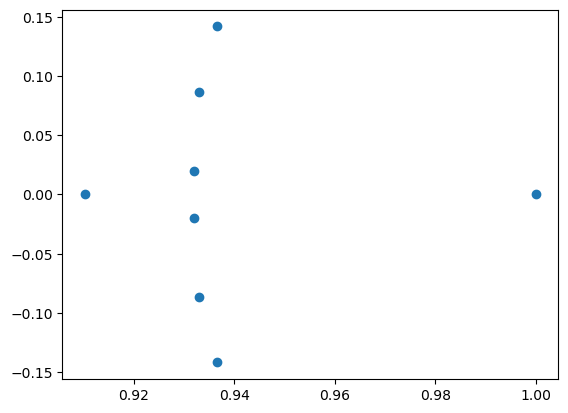

In [93]:
import matplotlib.pyplot as plt

x= [ele.real for ele in Phi]
y= [ele.imag for ele in Phi]

plt.scatter(x,y)
plt.show